Ho: there are 5 positions to account for every player (PG, SG, SF, PF, C)

Ha: the 5 position model is outdated and players fall into a more robust role distribution

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lib.NBA_functions import get_stats, get_corrs
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
pd.set_option('mode.chained_assignment', None)

# import sklearn
from sklearn import cluster, metrics, datasets
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [35]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

"Basketball on Paper: Rules and Tools for Performance Analysis" by Dean Oliver

[Calculating Individual Offensive and Defensive Ratings](https://www.basketball-reference.com/about/ratings.html "Basketball-Reference.com")

In [36]:
# per_100.csv contains 'per 100 possessions' player stats, importantly controlling for usage rate.
# if I player doesn't receive as many minutes but has good stats per 100 possessions, there may be
# an issue of being undervalued there

players = pd.read_csv("data/finaldata.csv")
players = players.drop('Unnamed: 0', axis = 1)

players.head()

,Last Name,First Name,Full Name,Year,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,height,weight,shoots,salary,Dist.,2P_A,0-3_A,3-10_A,10-16_A,16-3pt_A,3P_A,0-3%,3-10%,10-16%,16-3pt%,Astd_2P,Dunk%,Dunks_Md,Astd_3P,%Corner3_A,Corner_3P%,Heaves_A,Heaves_Md
0,Abrines,Álex,Álex Abrines,2018.0,SG,25.0,OKC,31.0,2.0,588.0,4.4,12.5,0.357,3.3,10.1,0.323,1.2,2.4,0.500,1.0,1.0,0.923,0.4,3.4,3.8,1.6,1.3,0.5,1.1,4.2,13.1,103.0,111.0,6.3,0.507,0.809,0.083,0.9,7.8,4.2,4.3,1.3,0.9,7.9,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acy,Quincy,Quincy Acy,2018.0,PF,28.0,PHO,10.0,0.0,123.0,1.6,7.0,0.222,0.8,5.8,0.133,0.8,1.2,0.667,2.7,3.9,0.700,1.2,8.5,9.7,3.1,0.4,1.6,1.6,9.3,6.6,87.0,116.0,2.9,0.379,0.833,0.556,2.7,20.1,11.3,8.2,0.4,2.7,15.2,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1,NaN,NaN,NaN,213948.0,21.7,0.167,0.111,0.000,0.056,0.000,0.833,1.000,NaN,0.000,NaN,1.000,0.000,0.0,1.000,0.333,0.200,0.0,0.0
2,Adams,Jaylen,Jaylen Adams,2018.0,PG,22.0,ATL,34.0,1.0,428.0,4.1,11.9,0.345,2.7,8.0,0.338,1.4,3.9,0.361,0.8,1.0,0.778,1.2,5.3,6.5,7.0,1.5,0.5,3.0,4.9,11.7,99.0,115.0,7.6,0.474,0.673,0.082,2.6,12.3,7.4,19.8,1.5,1.0,19.7,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3,NaN,NaN,NaN,236854.0,20.2,0.327,0.118,0.082,0.073,0.055,0.673,0.538,0.111,0.250,0.500,0.231,0.000,0.0,0.840,0.149,0.182,1.0,0.0
3,Adams,Steven,Steven Adams,2018.0,C,25.0,OKC,80.0,80.0,2669.0,8.4,14.1,0.595,0.0,0.0,0.000,8.4,14.1,0.596,2.6,5.1,0.500,6.8,6.5,13.3,2.2,2.0,1.3,2.4,3.6,19.4,120.0,106.0,18.5,0.591,0.002,0.361,14.7,14.8,14.7,6.6,2.0,2.4,12.6,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2,NaN,NaN,NaN,24157304.0,3.5,0.998,0.645,0.294,0.058,0.000,0.002,0.667,0.458,0.511,NaN,0.642,0.190,131.0,NaN,0.000,NaN,2.0,0.0
4,Adebayo,Bam,Bam Adebayo,2018.0,C,21.0,MIA,82.0,28.0,1913.0,7.2,12.4,0.576,0.1,0.4,0.200,7.1,12.0,0.588,4.2,5.8,0.735,4.2,11.0,15.2,4.7,1.8,1.7,3.1,5.2,18.6,120.0,104.0,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,NaN,NaN,NaN,2955840.0,5.2,0.969,0.572,0.243,0.121,0.033,0.031,0.716,0.415,0.373,0.438,0.700,0.257,117.0,0.667,0.267,0.000,2.0,0.0


In [37]:
print(players.Pos.unique())

['SG' 'PF' 'PG' 'C' 'SF' 'PF-SF' 'SF-SG' 'SG-PF' 'C-PF' 'SG-SF' 'PF-C'
 'PG-SG' 'SG-PG' 'SF-PF' 'PG-SF' nan]


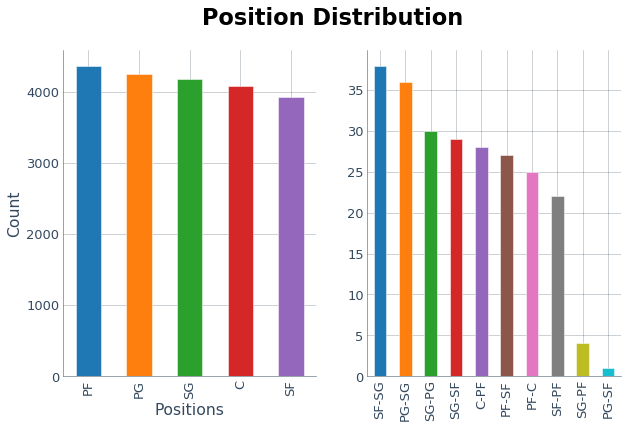

In [38]:
a = players['Pos'].value_counts()[:5]
b = players['Pos'].value_counts()[5:]

plt.subplots(nrows = 1, ncols = 2)
plt.subplot(1,2,1)
a.plot(kind = 'bar')
plt.xlabel('Positions')
plt.ylabel('Count')
#plt.title('Position Distribution')
plt.subplot(1,2,2)
b.plot(kind = 'bar')
plt.suptitle('Position Distribution')
plt.show()

The right chart above gives frequncies of players who have held multiple positions across one season. In every case, the players were only listed at multiple positions because they played for multiple teams in that season and the unique teams listed the player at different positions. If, for example, a player was listed as PG for one team, was traded to another and they used him as a shooting guard (SG), our data would have that player listed as having team 'TOT' for total and his position as 'PG-SG'. These players make up a minority of our data, of course, but give further legitimacy to our hypothesis that player positions ought not be considered hard and fast as simply point guard through center.

In [39]:
fluid = list(players['Pos'].value_counts().index.unique()[5:])

players[players['Pos'].isin(fluid)].iloc[:,[2,3,4,6]].head(3).append(players[players['Pos'].isin(fluid)].iloc[:,[2,3,4,6]].tail(3))


,Full Name,Year,Pos,Tm
38,Harrison Barnes,2018.0,PF-SF,TOT
102,Jimmy Butler,2018.0,SF-SG,TOT
128,Wilson Chandler,2018.0,PF-SF,TOT
20816,Lionel Hollins,1979.0,SG-PG,TOT
20912,Eric Money,1979.0,SG-PG,TOT
20972,Bingo Smith,1979.0,SF-SG,TOT


## Data Preprocessing

In [40]:
scal = 10     # 'scal' for 'starter-calibre', where scal will signify 14 or more games 
              # started; played with this number until I got 50% of the player base 
              # (only the years 2000 - 2017 have all features available)
n = 8 # number of clusters

full = players[players.Year > 1999].fillna(0).groupby('Full Name', sort = False).mean().reset_index().set_index('Full Name')

pos = players[players.Year > 1999].groupby('Full Name', sort = False).Pos.last()
full['Pos'] = pos

starters = full[full.GS >= scal]

data = starters.drop(['Year','G','GS','MP','salary','height','weight'], axis = 1)
X = data.drop(['Pos'], axis = 1)
y = data['Pos']

print('With a floor metric of',scal,'games played for the season,we can \nlook at',len(starters),
      'out of', len(full), 'possible players in between',int(min(starters.Year)),'and',int(max(starters.Year)))
print('--a sample of',round(len(starters)/len(full),2)*100, '% of the players available. \n')

With a floor metric of 10 games played for the season,we can 
look at 769 out of 2046 possible players in between 2000 and 2018
--a sample of 38.0 % of the players available. 



Right away we see that controlling for games started gives us a more appropriate number of players to consider. This gives us a more reasonable number of 156 for the 2018-2019 season, or approximately 5 players per team (of which there are currently 30). We can do the same transformation with a low-bar of 10 starts and get about 10 players per team on average.

In [41]:
# scale the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction with PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.4619543009282062


In [42]:
# Dimentionality Reduction with LDA, RDA, QDA

LDA = LinearDiscriminantAnalysis(n_components=2, shrinkage='auto', solver='eigen')

LDA_reduced_df = LDA.fit(X_scaled,y).transform(X_scaled)

print(LDA.score(X_scaled,y))


0.6892067620286085


**LDA explanation here.**

In [43]:
SS = []

for k in range(2, 11):
    kmeans_cluster = KMeans(n_clusters = k, random_state=23).fit(LDA_reduced_df)
    SS.append(kmeans_cluster.inertia_)

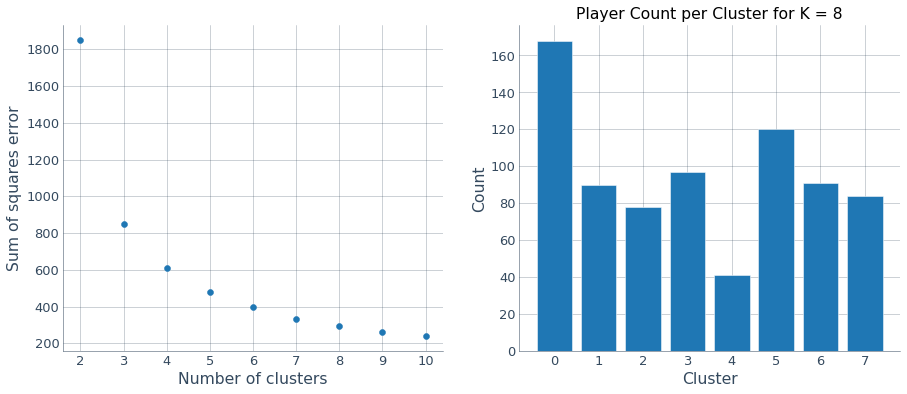

In [44]:
plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

plt.subplot(121)
plt.scatter(range(2,11), SS)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squares error")

plt.subplot(122)

kmeans_cluster = KMeans(n_clusters = n, random_state=23).fit(LDA_reduced_df)

counts = [0 for i in range(n)]
for i in range(n):
    for label in kmeans_cluster.labels_:
        if label == i:
            counts[i] += 1

plt.bar(range(n), counts)
#plt.xticks([0,1,2])
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Player Count per Cluster for K = "+str(n))
plt.show()

In [45]:
kmeans = cluster.KMeans(n_clusters = n, random_state = 23)
kmeans = kmeans.fit(LDA_reduced_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

centroid_x = [coord[0] for coord in centroids]
centroid_y = [coord[1] for coord in centroids]

intertia = kmeans.inertia_
sil_score = metrics.silhouette_score(LDA_reduced_df, kmeans.labels_, metric = 'euclidean')

In [46]:
data['cluster'] = labels
one = [value[0] for value in LDA_reduced_df]
two = [value[1] for value in LDA_reduced_df]
data['one'] = one
data['two'] = two

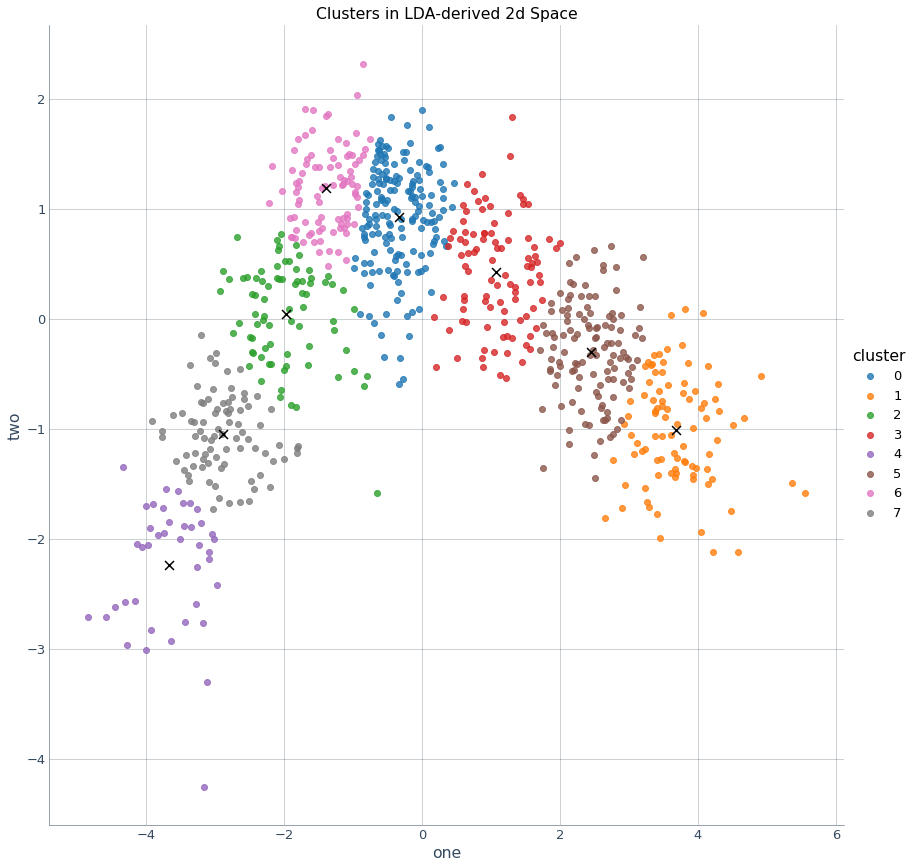

In [47]:
sns.lmplot('one','two', data = data, hue = 'cluster', fit_reg=False, height = 12)
plt.scatter(centroid_x, centroid_y, marker = 'x', s = 80, c = 'black')
plt.title('Clusters in LDA-derived 2d Space')

plt.show()

<Figure size 720x576 with 0 Axes>

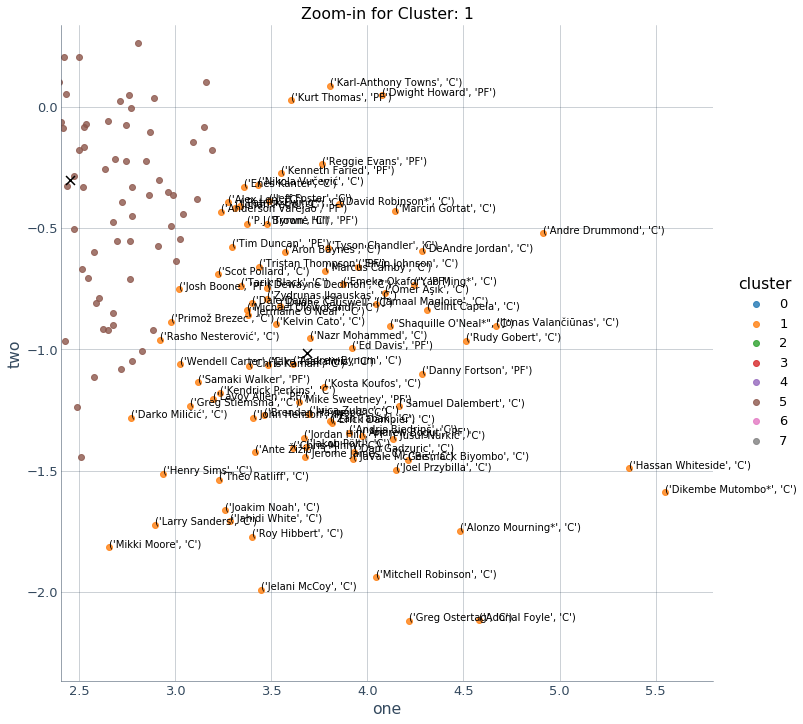

In [48]:
# annotate only designated cluster: 'cluster'

cluster_num = 1

names = data.index
positions = data['Pos']
#teams = data['Tm']

plt.figure(figsize = (10,8))

sns.lmplot('one','two', data = data, hue = 'cluster', fit_reg=False, height = 10)
plt.scatter(centroid_x, centroid_y, marker = 'x', s = 80, c = 'black')
for i,name in enumerate(zip(names,positions)):
    x = data.reset_index().one[i]
    y = data.reset_index().two[i]
    if data.reset_index().loc[i,'cluster'] == cluster_num:
        plt.text(x, y, name, fontsize=10)
        
# set zoom for cluster

xhigh = max(data[data.cluster == cluster_num].one) + 0.25
xlow = min(data[data.cluster == cluster_num].one) - 0.25
yhigh = max(data[data.cluster == cluster_num].two) + 0.25
ylow = min(data[data.cluster == cluster_num].two) - 0.25

plt.xlim([xlow,xhigh])
plt.ylim([ylow,yhigh])

plt.title('Zoom-in for Cluster: '+ str(cluster_num))
plt.show()

In [49]:
cluster_list = []

league = data.drop(['Age','Pos','one','two','cluster'], axis = 1)

for i in range(n):

    cluster_df = data[data.cluster == i].drop(['Age','Pos','one','two','cluster'], axis = 1)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_df)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(list(zip(cluster_df.columns, pca.components_[0], np.mean(cluster_df), np.mean(league))),
                            columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False).head(10)
    features['Cluster'] = i
    features['Relative Difference'] = np.abs(1 - (features['Cluster Average']/features['League Average']))
    features = features[['Cluster', 'Feature', 'Importance', 'Cluster Average', 'League Average', 'Relative Difference']]
    features = features.reset_index().drop('index', axis = 1)
    
    cluster_list.append(features)
    
feature_importance = pd.concat(cluster_list).reset_index().drop('index', axis = 1)

In [50]:
feature_importance[feature_importance.Cluster == cluster_num]

,Cluster,Feature,Importance,Cluster Average,League Average,Relative Difference
10,1,PER,0.236208,14.565605,12.776784,0.140006
11,1,OWS,0.217997,1.544984,1.425881,0.083529
12,1,WS,0.215897,3.299276,2.799633,0.178467
13,1,OBPM,0.215220,-2.425178,-1.049960,1.309782
14,1,WS/48,0.208195,0.105743,0.077937,0.356765
15,1,PTS,0.200146,17.471449,18.521800,0.056709
16,1,VORP,0.196502,0.745519,0.685423,0.087677
17,1,FG,0.193294,6.996012,6.980380,0.002239
18,1,BPM,0.191712,-1.089593,-1.143870,0.047450
19,1,2P,0.187205,6.936703,5.637890,0.230372


### Cluster Descriptions
- Cluster 0: 3-and-D Wings 
- Cluster 1: Defensive Centers 
- Cluster 2: Scoring Wings 
- Cluster 3: Versatile Forwards
- Cluster 4: Floor Generals 
- Cluster 5: Offensive Centers 
- Cluster 6: Shooting Wings 
- Cluster 7: Combo Guards 

In [51]:
data.head()

,Age,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Dist.,2P_A,0-3_A,3-10_A,10-16_A,16-3pt_A,3P_A,0-3%,3-10%,10-16%,16-3pt%,Astd_2P,Dunk%,Dunks_Md,Astd_3P,%Corner3_A,Corner_3P%,Heaves_A,Heaves_Md,Pos,cluster,one,two
Full Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Steven Adams,22.5,6.900000,11.900000,0.575833,0.000000,0.016667,0.000000,6.900000,11.866667,0.577000,3.000000,5.400000,0.555833,6.216667,7.366667,13.566667,1.833333,1.566667,1.916667,2.650000,5.366667,16.850000,116.333333,105.166667,16.066667,0.586833,0.002000,0.477333,13.850000,16.100000,15.000000,5.366667,1.566667,3.133333,15.883333,14.650000,3.683333,2.750000,6.466667,0.143333,-0.100000,1.650000,1.566667,1.983333,3.083333,0.998000,0.648167,0.303500,0.042167,0.003667,0.002000,0.654000,0.440667,0.424333,0.083333,0.670833,0.213667,98.666667,0.000000,0.000000,0.000000,1.000000,0.0,C,5,2.697802,-0.552853
Bam Adebayo,20.5,6.800000,12.450000,0.544000,0.050000,0.350000,0.100000,6.750000,12.100000,0.555500,4.450000,6.200000,0.728000,4.250000,10.350000,14.600000,4.200000,1.500000,1.600000,2.750000,5.150000,18.050000,118.000000,104.500000,16.800000,0.596500,0.026000,0.495500,9.450000,22.800000,16.100000,12.600000,1.500000,2.750000,15.350000,15.850000,2.850000,2.650000,5.500000,0.159500,-1.100000,2.700000,1.600000,1.600000,4.750000,0.974000,0.598000,0.237500,0.101500,0.037000,0.026000,0.679000,0.372000,0.347000,0.326000,0.700500,0.275500,104.000000,0.333500,0.133500,0.000000,3.000000,0.0,C,5,2.273575,-0.526351
LaMarcus Aldridge,27.0,11.953846,24.338462,0.492692,0.192308,0.669231,0.207615,11.776923,23.684615,0.498308,5.392308,6.661538,0.804462,4.184615,8.553846,12.738462,2.884615,1.115385,1.669231,2.361538,3.869231,29.515385,112.307692,105.769231,20.846154,0.541308,0.026077,0.273769,9.200000,18.861538,14.046154,10.046154,1.115385,2.530769,8.030769,25.907692,5.169231,3.046154,8.215385,0.156538,0.869231,0.469231,1.330769,2.169231,10.784615,0.973923,0.253538,0.203154,0.208538,0.308769,0.026077,0.702692,0.448923,0.409308,0.421462,0.575385,0.062692,64.230769,0.704308,0.273769,0.216385,1.307692,0.0,C,5,2.184079,0.314614
Jarrett Allen,19.5,7.750000,13.150000,0.589500,0.150000,0.750000,0.233000,7.600000,12.400000,0.614000,4.150000,5.650000,0.742500,4.600000,9.550000,14.200000,2.100000,0.950000,2.850000,2.550000,4.600000,19.800000,121.000000,107.000000,18.000000,0.634000,0.058500,0.429500,10.050000,21.050000,15.550000,6.650000,0.950000,4.550000,14.050000,16.100000,3.550000,2.400000,5.900000,0.158000,-1.000000,2.300000,1.350000,1.600000,4.000000,0.941500,0.673000,0.226000,0.029500,0.012500,0.058500,0.711500,0.382000,0.250000,0.166500,0.836500,0.348000,143.500000,1.000000,0.867000,0.269500,1.000000,0.5,C,5,2.745237,0.659180
Al-Farouq Aminu,24.0,5.655556,13.455556,0.422556,1.500000,4.500000,0.305667,4.166667,8.933333,0.466000,2.711111,3.622222,0.743111,2.922222,9.322222,12.244444,2.466667,1.988889,1.200000,2.533333,3.888889,15.533333,103.111111,106.000000,12.300000,0.516444,0.328778,0.271111,6.433333,20.566667,13.500000,7.155556,1.988889,1.911111,14.344444,15.377778,0.833333,2.188889,3.055556,0.075222,-1.488889,1.400000,-0.077778,0.944444,12.122222,0.671222,0.354444,0.158556,0.044667,0.112889,0.328778,0.602000,0.334000,0.290111,0.265333,0.572000,0.093222,39.888889,0.984333,0.403333,0.348000,0.555556,0.0,SF,3,0.864489,1.311523


In [53]:
Label = data[['Pos','cluster']]
Label['cluster'] = Label['cluster'].map({0:'3-and-D Wing',
                                         1:'Defensive Center',
                                         2:'Scoring Wing',
                                         3:'Versatile Forward',
                                         4:'Floor General',
                                         5:'Offensive Center',
                                         6:'Shooting Wing',
                                         7:'Combo Guard'})

In [27]:
file_loc = 'data/player_labels.csv'

Label.to_csv(file_loc)

In [28]:
print(Label.shape)
print(starters.shape)

new_positions = pd.merge(Label.reset_index(), starters.drop('Pos', axis = 1).reset_index(), on = 'Full Name').set_index('Full Name')
new_positions.head()

(769, 2)
(769, 71)


,Pos,cluster,Year,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,height,weight,salary,Dist.,2P_A,0-3_A,3-10_A,10-16_A,16-3pt_A,3P_A,0-3%,3-10%,10-16%,16-3pt%,Astd_2P,Dunk%,Dunks_Md,Astd_3P,%Corner3_A,Corner_3P%,Heaves_A,Heaves_Md
Full Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Steven Adams,C,Offensive Center,2015.5,22.5,77.833333,67.166667,2087.833333,6.900000,11.900000,0.575833,0.000000,0.016667,0.000000,6.900000,11.866667,0.577000,3.000000,5.400000,0.555833,6.216667,7.366667,13.566667,1.833333,1.566667,1.916667,2.650000,5.366667,16.850000,116.333333,105.166667,16.066667,0.586833,0.002000,0.477333,13.850000,16.100000,15.000000,5.366667,1.566667,3.133333,15.883333,14.650000,3.683333,2.750000,6.466667,0.143333,-0.100000,1.650000,1.566667,1.983333,70.000000,220.833333,9.387435e+06,3.083333,0.998000,0.648167,0.303500,0.042167,0.003667,0.002000,0.654000,0.440667,0.424333,0.083333,0.670833,0.213667,98.666667,0.000000,0.000000,0.000000,1.000000,0.0
Bam Adebayo,C,Offensive Center,2017.5,20.5,75.500000,23.500000,1640.500000,6.800000,12.450000,0.544000,0.050000,0.350000,0.100000,6.750000,12.100000,0.555500,4.450000,6.200000,0.728000,4.250000,10.350000,14.600000,4.200000,1.500000,1.600000,2.750000,5.150000,18.050000,118.000000,104.500000,16.800000,0.596500,0.026000,0.495500,9.450000,22.800000,16.100000,12.600000,1.500000,2.750000,15.350000,15.850000,2.850000,2.650000,5.500000,0.159500,-1.100000,2.700000,1.600000,1.600000,41.000000,127.500000,2.723100e+06,4.750000,0.974000,0.598000,0.237500,0.101500,0.037000,0.026000,0.679000,0.372000,0.347000,0.326000,0.700500,0.275500,104.000000,0.333500,0.133500,0.000000,3.000000,0.0
LaMarcus Aldridge,C,Offensive Center,2012.0,27.0,73.076923,69.923077,2520.307692,11.953846,24.338462,0.492692,0.192308,0.669231,0.207615,11.776923,23.684615,0.498308,5.392308,6.661538,0.804462,4.184615,8.553846,12.738462,2.884615,1.115385,1.669231,2.361538,3.869231,29.515385,112.307692,105.769231,20.846154,0.541308,0.026077,0.273769,9.200000,18.861538,14.046154,10.046154,1.115385,2.530769,8.030769,25.907692,5.169231,3.046154,8.215385,0.156538,0.869231,0.469231,1.330769,2.169231,76.615385,240.000000,1.307430e+07,10.784615,0.973923,0.253538,0.203154,0.208538,0.308769,0.026077,0.702692,0.448923,0.409308,0.421462,0.575385,0.062692,64.230769,0.704308,0.273769,0.216385,1.307692,0.0
Jarrett Allen,C,Offensive Center,2017.5,19.5,76.000000,55.500000,1768.500000,7.750000,13.150000,0.589500,0.150000,0.750000,0.233000,7.600000,12.400000,0.614000,4.150000,5.650000,0.742500,4.600000,9.550000,14.200000,2.100000,0.950000,2.850000,2.550000,4.600000,19.800000,121.000000,107.000000,18.000000,0.634000,0.058500,0.429500,10.050000,21.050000,15.550000,6.650000,0.950000,4.550000,14.050000,16.100000,3.550000,2.400000,5.900000,0.158000,-1.000000,2.300000,1.350000,1.600000,41.500000,118.500000,1.873920e+06,4.000000,0.941500,0.673000,0.226000,0.029500,0.012500,0.058500,0.711500,0.382000,0.250000,0.166500,0.836500,0.348000,143.500000,1.000000,0.867000,0.269500,1.000000,0.5
Al-Farouq Aminu,SF,Versatile Forward,2014.0,24.0,74.444444,47.666667,1876.000000,5.655556,13.455556,0.422556,1.500000,4.500000,0.305667,4.166667,8.933333,0.466000,2.711111,3.622222,0.743111,2.922222,9.322222,12.244444,2.466667,1.988889,1.200000,2.533333,3.888889,15.533333,103.111111,106.000000,12.300000,0.516444,0.328778,0.271111,6.433333,20.566667,13.500000,7.155556,1.988889,1.911111,14.344444,15.377778,0.833333,2.188889,3.055556,0.075222,-1.488889,1.400000,-0.077778,0.944444,72.000000,195.555556,4.711652e+06,12.122222,0.671222,0.354444,0.158556,0.044667,0.112889,0.328778,0.602000,0.334000,0.290111,0.265333,0.572000,0.093222,39.888889,0.984333,0.403333,0.348000,0.555556,0.0


In [29]:
file_loc2 = "data/new_positions.csv"

new_positions.to_csv(file_loc2)

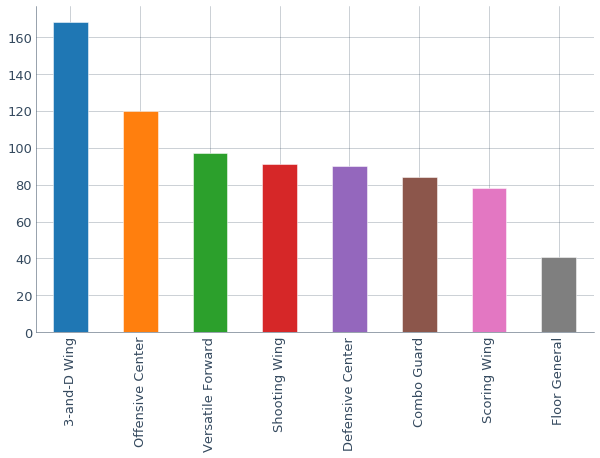

In [30]:
new_positions.cluster.value_counts().plot(kind = 'bar')